In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Flatten, Input
import tensorflow as tf

import pandas as pd
import numpy as np

from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calender
import calendar


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams
from matplotlib import pyplot as plot


from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# math function
from math import sqrt

# evaluation metrics
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

import itertools

# libraries to filter warnings in some algorithms
import warnings
warnings.filterwarnings("ignore")

In [2]:
#import data
data = pd.read_csv('../Paper1/murdoch_system_incoming_traffic.csv', infer_datetime_format=True,
                  parse_dates=['Date'], index_col='Date',
                   names=['sender','Date', 'traffic', 
                                         'user'])

In [3]:
data.head()

,sender,traffic,user
Date,,,
2015-09-13 00:00:04,received,2170,system
2015-09-13 00:00:04,received,788,system
2015-09-13 00:00:11,received,808,system
2015-09-13 00:00:38,received,1710,system
2015-09-13 00:00:18,received,7668,system


In [4]:
#drop decoded frame column

data.drop(('user'), axis=1, inplace=True)
data.drop(('sender'), axis=1, inplace=True)

In [5]:
# view the first few rows and the headers

data.head()

,traffic
Date,
2015-09-13 00:00:04,2170
2015-09-13 00:00:04,788
2015-09-13 00:00:11,808
2015-09-13 00:00:38,1710
2015-09-13 00:00:18,7668


In [6]:
# make dataset numeric
data = data.astype('float32')

# show descriptive stats:
# summarize dataset
print("Shape of the dataset :", data.shape)
print()
print("First rows of the dataset :", data.head())
print()
print("Statistics on the dataset :",data.describe())

Shape of the dataset : (1160924, 1)

First rows of the dataset :                      traffic
Date                        
2015-09-13 00:00:04   2170.0
2015-09-13 00:00:04    788.0
2015-09-13 00:00:11    808.0
2015-09-13 00:00:38   1710.0
2015-09-13 00:00:18   7668.0

Statistics on the dataset :             traffic
count  1.160924e+06
mean   2.978874e+04
std    5.270758e+05
min    0.000000e+00
25%    9.570000e+02
50%    1.828000e+03
75%    4.913000e+03
max    1.512183e+08


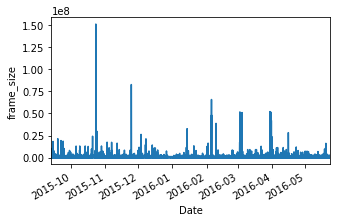

In [7]:

plt.figure(figsize= (5,3))
data['traffic'].plot()
plt.ylabel("frame_size")
plt.show()

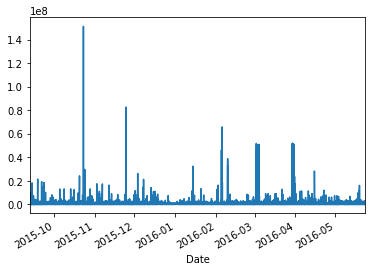

In [8]:
data['traffic'].plot()

In [9]:
data = pd.DataFrame(data["traffic"].resample("h").mean())
print(data.head())


                         traffic
Date                            
2015-09-13 00:00:00  7531.185059
2015-09-13 01:00:00  6540.654785
2015-09-13 02:00:00  6303.699219
2015-09-13 03:00:00  9022.992188
2015-09-13 04:00:00  5678.010742


In [10]:
#Check for missing values
print("total number of rows : {0}".format(len(data)))
print("number of rows missing traffic: {0}".format(len(data.loc[data['traffic'] == 0])))
print(data.head())

#Fill missing values
data = data.replace(0, np.nan) # first replace 0 values with nan values, otherwise fill function doesnot work
#daily_data.fillna(method= 'bfill', inplace=True) # fill using backward fill pandas function
data.interpolate(method= 'linear', inplace=True)


#Check how many other missing(zero) values
print("total number of rows : {0}".format(len(data)))
print("number of rows missing traffic: {0}".format(len(data.loc[data['traffic'] == 0])))
print(data.head())

total number of rows : 6090
number of rows missing traffic: 0
                         traffic
Date                            
2015-09-13 00:00:00  7531.185059
2015-09-13 01:00:00  6540.654785
2015-09-13 02:00:00  6303.699219
2015-09-13 03:00:00  9022.992188
2015-09-13 04:00:00  5678.010742
total number of rows : 6090
number of rows missing traffic: 0
                         traffic
Date                            
2015-09-13 00:00:00  7531.185059
2015-09-13 01:00:00  6540.654785
2015-09-13 02:00:00  6303.699219
2015-09-13 03:00:00  9022.992188
2015-09-13 04:00:00  5678.010742


# ***Test stationarity***
The data is stationary if the mean, variance and covariance are constant over the period

***Using Adfuller test***

In [11]:
# check if stationary
result = adfuller(data.traffic)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.378716
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [12]:
def adfuller_test(traffic):
    result=adfuller(traffic)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data has no unit root and is stationary")
    else:
        print("Data has a unit root, indicating it is non-stationary ")

In [13]:
adfuller_test(data['traffic'])

ADF Test Statistic : -7.378716061066087
p-value : 8.584859246585551e-11
#Lags Used : 28
Number of Observations Used : 6061
Data has no unit root and is stationary


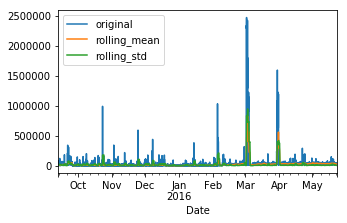

In [14]:
#moving average
rolling_mean = data.traffic.rolling(window=30).mean()
rolling_std = data.traffic.rolling(window=30).std()

plt.figure(figsize= (5,3))
data.traffic.plot(label='original')
rolling_mean.plot(label='rolling_mean')
rolling_std.plot(label='rolling_std')
plt.legend(loc='best')
plt.show()

***Using Autocorrelation function (ACF) and partial autocorrelation function(PCAF)***

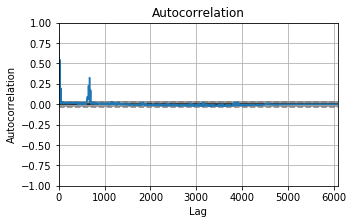

In [15]:
plt.figure(figsize= (5,3))
autocorrelation_plot(data.traffic)
plt.title("Autocorrelation")
plt.show()


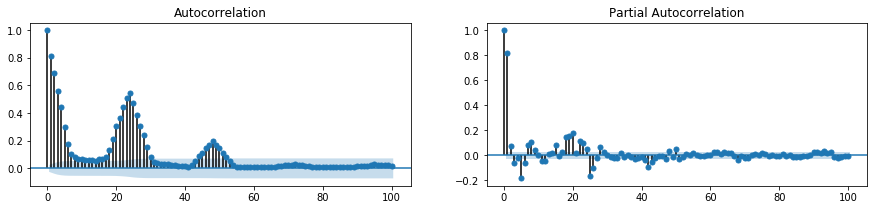

In [16]:
# Calculate ACF and PACF upto 50 lags

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,3))
plot_acf(data.traffic, lags =100, ax = ax1)
plot_pacf(data.traffic, lags =100, ax = ax2)
plt.show()

# ***Make data stationary***

***Using first order differencing***

In [17]:
#First order differencing

data['first_diff']= data['traffic'].diff()
data.dropna(inplace=True)
data.head()

,traffic,first_diff
Date,,
2015-09-13 01:00:00,6540.654785,-990.530273
2015-09-13 02:00:00,6303.699219,-236.955566
2015-09-13 03:00:00,9022.992188,2719.292969
2015-09-13 04:00:00,5678.010742,-3344.981445
2015-09-13 05:00:00,10396.909180,4718.898438


In [18]:
## Again test dickey fuller test

adfuller_test(data['first_diff'].dropna())

ADF Test Statistic : -23.19647179764821
p-value : 0.0
#Lags Used : 27
Number of Observations Used : 6061
Data has no unit root and is stationary


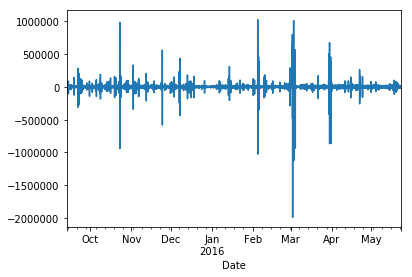

In [19]:

data['first_diff'].plot()

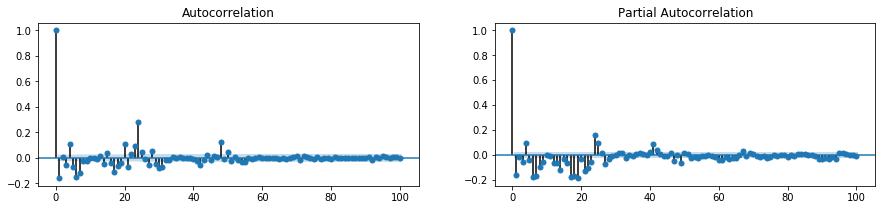

In [20]:
# Calculate ACF and PACF upto 50 lags

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,3))
plot_acf(data['first_diff'], lags =100, ax = ax1)
plot_pacf(data['first_diff'], lags =100, ax = ax2)
plt.show()

# Model

In [21]:
# *****************split into train and test sets********************
dataset= data['traffic'].copy()

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
trainset = dataset[0:train_size]
testset= dataset[train_size:len(dataset)]
print('Data_train', trainset.shape, 'Data_test',testset.shape)


Data_train (4871,) Data_test (1218,)


***Model 1: Autoregressive Integrated Moving Average (ARIMA)***

In [22]:
#This model involves specifying the order for the AR(p), I(d), and MA(q) models
# Define the p, d and q parameters to take any value between 0 and 2
p = range(0,8)
d = range(0,2)
q = range(0,1)

In [23]:
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

In [24]:
best_aic = np.inf
best_pdq = None
temp_model = None
for param in pdq:   
    temp_model = ARIMA(trainset,order=param)
    results = temp_model.fit()
    if results.aic < best_aic:
        best_aic = results.aic
        best_pdq = param 
print("Best ARIMA {} model - AIC:{}".format(best_pdq,best_aic))

Best ARIMA (7, 0, 0) model - AIC:122290.33630846448


In [25]:
# using the best parameter in the model
model = ARIMA(trainset,order=(7,0,0))
model_fit = model.fit()

In [26]:
predictions = model_fit.predict(start=len(trainset), end=len(trainset)+len(testset)-1)

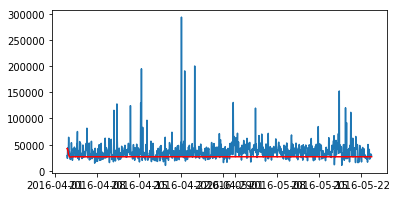

In [27]:
# plot results
plt.figure(figsize=(6,3))
plt.plot(testset)
plt.plot(predictions, color='red')
plt.show()

In [28]:
#Prediction

# Relative Percentage Error
def mean_relative_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_pred), np.array(y_true)
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(testset, predictions))
rmse = round(rmse, 3)
print('RMSE', rmse)

rpe = mean_relative_percentage_error(testset, predictions)
print ('RPE', rpe)

# Mean Absolute Percentage Error
abs_error = np.abs(testset-predictions)
actual = testset
mape = np.round(np.mean(np.abs(abs_error/actual)),3)
print('MAPE', mape)

RMSE 19873.994
RPE 27.13521465876828
MAPE 0.271


In [29]:
# Storing results in a dataframe
tempResultsDf = pd.DataFrame({'Method':['Autoregressive Integrated Moving Average'], 'RMSE': [rmse],'MAPE': [mape],
                              'RPE': [rpe] })
resultsDf = pd.concat([tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE', 'RPE']]
resultsDf

,Method,RMSE,MAPE,RPE
0,Autoregressive Integrated Moving Average,19873.994,0.271,27.135215


***Model 2: Seasonal Autoregressive Integrated Moving Average (SARIMA)***

In [30]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

In [31]:
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [32]:
#Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [33]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None
for param in pdq:   
    for param_seasonal in seasonal_pdq: 
        temp_model = SARIMAX(trainset,order=param,seasonal_order = param_seasonal,enforce_invertibility=False,
                             enforce_stationarity=False)
        results = temp_model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_seasonal_pdq = param_seasonal
print("Best ARIMA {} x {} model - AIC:{}".format(best_pdq,best_seasonal_pdq,best_aic))

Best ARIMA (1, 0, 1) x (1, 0, 1, 12) model - AIC:122063.83329122385


In [34]:

# using the best parameter in the model
model = SARIMAX(trainset,order=(1,1,1),seasonal_order=(1,1,1,12),enforce_invertibility=False,
                             enforce_stationarity=False)
model_fit = model.fit()

In [35]:
predictions = model_fit.predict(start=len(trainset), end=len(trainset)+len(testset)-1)

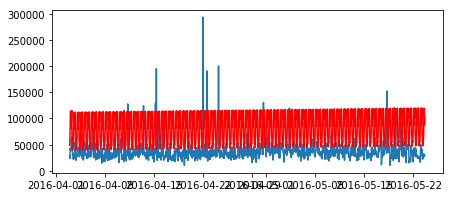

In [37]:
# plot results
plt.figure(figsize=(7,3))
plt.plot(testset)
plt.plot(predictions, color='red')
plt.show()

In [38]:
#Prediction

# Relative Percentage Error
def mean_relative_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_pred), np.array(y_true)
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(testset, predictions))
rmse = round(rmse, 3)
print('RMSE', rmse)

rpe = mean_relative_percentage_error(testset, predictions)
print ('RPE', rpe)

# Mean Absolute Percentage Error
abs_error = np.abs(testset-predictions)
actual = testset
mape = np.round(np.mean(np.abs(abs_error/actual)),3)
print('MAPE', mape)

RMSE 50206.497
RPE 133.66888101412783
MAPE 1.337


In [39]:
# Storing results in a dataframe
tempResultsDf = pd.DataFrame({'Method':['Seasonal Autoregressive Integrated Moving Average'], 'RMSE': [rmse],
                              'MAPE': [mape],'RPE': [rpe] })
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE', 'RPE']]
resultsDf.index = [i for i in range(len(resultsDf))]
resultsDf

,Method,RMSE,MAPE,RPE
0,Autoregressive Integrated Moving Average,19873.994,0.271,27.135215
1,Seasonal Autoregressive Integrated Moving Average,50206.497,1.337,133.668881


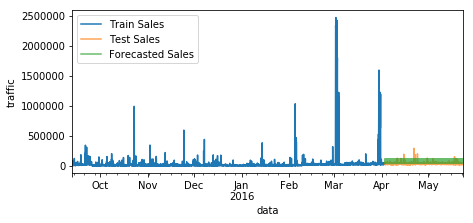

In [40]:
axis = trainset.plot(label='Train Sales', figsize=(7, 3))
testset.plot(ax=axis, label='Test Sales', alpha=0.7)
predictions.plot(ax=axis, label='Forecasted Sales', alpha=0.7)
axis.set_xlabel('data')
axis.set_ylabel('traffic')
plt.legend(loc='best')
plt.show()
plt.close()